# Picture memory

This builds on the P300 and WR example.

Design
* study-test recognition memory 
* Study phase: 50 pictures were presented for 2s and judged "like" or "dislike", indicated by a button press
* Test phase: The same 50 studied items were presented with 50 distractor items in pseudo-random order and judged "old" or "new".
* The 50 studied and 50 distractor items are counterbalanced across subjects so the individual pictures are studied for half the participants and distractors for the other half.

Automated code tagging 
 * tag individual stimulus items are 
 * stimulus categories
 * response categories
 * **local** (within-trial) stimulus-response contigent tags: "old", "new", "hit", "miss", "correct rejection", "false alarm"
 
Event table modification for custom code tagging
 * **non-local** (across-phase) response-contingent tags 
 * separate codemaps and event tables are constructed for the study and test phases
 * DM analysis: align the study phase items with subsequent test phase "hit", "miss" responses
 * Memory x preference: align the test phase items with previous study phase "like", "dislike" responses
 
 




In [1]:
import os
from pathlib import Path
import re
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from mkpy import mkh5
from spudtr import epf

# path wrangling for nbsphinx
if "MDE_HOME" in os.environ.keys():
    MDE_HOME = Path(os.environ["MDE_HOME"])
else:
    from conf import MDE_HOME as MDE_HOME

In [2]:
%%bash
conda list | egrep "(mkpy|spudtr)"

mkpy                      0.2.3                0_gc7b31fa    kutaslab
spudtr                    0.0.9                g0e166be_0    kutaslab/label/pre-release


In [3]:
# set filenames
crw = MDE_HOME / "mkdig/sub000pm.crw"    # EEG recording
log = MDE_HOME / "mkdig/sub000pm.x.log"  # events 
yhdr = MDE_HOME / "mkpy/sub000pm.yhdr"   # extra header info

# set calibration data filenames
cals_crw = MDE_HOME / "mkdig/sub000c.crw"
cals_log = MDE_HOME / "mkdig/sub000c.x.log"
cals_yhdr = MDE_HOME / "mkpy/sub000c.yhdr"

# HDF5 file with EEG recording, events, and header
pm_h5_f = MDE_HOME / "data/sub000pm.h5"  

**mkh5**  EEG data, event code log, header information

In [4]:
# convert to HDF5
pm_h5 = mkh5.mkh5(pm_h5_f)
pm_h5.reset_all()
pm_h5.create_mkdata("sub000", crw, log, yhdr)

# add calibration data
pm_h5.append_mkdata("sub000", cals_crw, cals_log, cals_yhdr)

# calibrate
pts, pulse, lo, hi, ccode = 5, 10, -40, 40, 0
pm_h5.calibrate_mkdata(
    "sub000",  # data group to calibrate with these cal pulses
    n_points=pts,  # pts to average
    cal_size=pulse,  # uV
    lo_cursor=lo,  # lo_cursor ms
    hi_cursor=hi,  # hi_cursor ms
    cal_ccode=ccode,  # condition code
)

/home/turbach/miniconda3/envs/mkconda_for_sphinxdocs/lib/python3.6/site-packages/mkpy/mkh5.py:3706: UserWarning: negative event code(s) found for cal condition code 0 -16384
  warnings.warn(msg)


Found cals in /sub000/dblock_3
Calibrating block /sub000/dblock_0 of 4: (95232,)  


Calibrating block /sub000/dblock_1 of 4: (34048,)  


Calibrating block /sub000/dblock_2 of 4: (139008,)  


Calibrating block /sub000/dblock_3 of 4: (28416,)  


**codemaps: study and test phase** generated programmatically from a table of item information

**item information**

Begin with the item-specific information, gathered somehow.

Here `awk` extracts a flat text file directly from the actual stimulus presentation files. 

*condition_id* tracks animacy and *item_id* tracks the item. 

*jpg* is the image file prefix for human readability and *scn* file tracks the version of the stimulus presentation file which counterbalance the 50 study items so of the 100 test items, across subjects, each individual picture appears equally often as previously presented or not. 

In [5]:
%%bash

awk -f ${MDE_HOME}/mkpy/get_pictmem_items.awk ${MDE_HOME}/mkstim/pictmem/*.scn > ${MDE_HOME}/mkpy/pm_item_id_by_scn.tsv

echo "study phase head"
column -t ${MDE_HOME}/mkpy/pm_item_id_by_scn.tsv | head
echo

echo "test phase tail"
column -t ${MDE_HOME}/mkpy/pm_item_id_by_scn.tsv | tail

study phase head
ccode  phase  condition_id  item_id  jpg       scn
2      study  2             154      necklace  studyp1
2      study  2             107      bell      studyp1
2      study  1             146      leopard   studyp1
2      study  1             157      peas      studyp1
2      study  2             151      moon      studyp1
2      study  2             143      jacket    studyp1
2      study  2             147      lighter   studyp1
2      study  2             141      htarblon  studyp1
2      study  2             149      lock      studyp1

test phase tail
1      test   1             144      kilerwal  testp4
1      test   2             187      table     testp4
1      test   4             111      briefcas  testp4
1      test   4             197      whistle   testp4
1      test   4             200      wrench    testp4
1      test   4             152      motrcyle  testp4
1      test   2             120      chair     testp4
1      test   3             186      swan 

In [6]:
# read the item information table
pm_items = pd.read_csv(
    MDE_HOME / "mkpy/pm_item_id_by_scn.tsv",
    delim_whitespace=True
).query("scn in ['studyp1', 'testp1']")

display(pm_items.head())
display(pm_items.tail())

,ccode,phase,condition_id,item_id,jpg,scn
0,2,study,2,154,necklace,studyp1
1,2,study,2,107,bell,studyp1
2,2,study,1,146,leopard,studyp1
3,2,study,1,157,peas,studyp1
4,2,study,2,151,moon,studyp1


,ccode,phase,condition_id,item_id,jpg,scn
295,1,test,4,198,wineglas,testp1
296,1,test,4,125,crayon,testp1
297,1,test,3,175,sheep,testp1
298,1,test,4,184,stove,testp1
299,1,test,2,105,barn,testp1


**study phase codemap**

* define a *code pattern: tags* template
* plug in the individual items
* save the result

Note that many-to-many mapping. Many codes (1, 2) are mapped to many tags, e.g., "like", "dislike"

In [7]:
# study phase codemape file name
pm_study_codemap_f = MDE_HOME / "mkpy/pm_study_codemap.tsv"

pm_study_codemap_cols = ["regexp", "study_bin_id", "animacy", "study_response", ] + list(pm_items.columns)

# stimulus-response tag template as a Python dictionary 
# The key:val pair says "this code sequence gets these tags"
# The ITEM_ID string will be replaced by the actual 3-digit item number

study_code_tags = {
    "(#[12]) 8 (ITEM_ID) 1040": (2000, "like"),
    "(#[12]) 8 1040 (ITEM_ID)": (2001, "like"),
    "(#[12]) 1040 8 (ITEM_ID)": (2002, "like"),
 
    "(#[12]) 8 (ITEM_ID) 2064": (2100, "dislike"),
    "(#[12]) 8 2064 (ITEM_ID)": (2101, "dislike"),
    "(#[12]) 2064 8 (ITEM_ID)": (2102, "dislike"),
    
    "(#[12]) 8 (ITEM_ID) (?!(1040|2064))": (2003, "no_response"),
}

# the new 4-digit "study_bin_id" tag re-codes the match event 1 or 2 with more information
#
#  phase animacy response response_timing
#    phase: study=2
#    animacy: 1=animate, 2=inanimate
#    response(0=like, 1=dislike)
#    response timing: 0=prompted,1,2 anticipation, 3=no response)
#
study_code_tags = {
    # animate
    "(#[1]) 8 (ITEM_ID) 1040": (2100, "animate", "like"),
    "(#[1]) 8 1040 (ITEM_ID)": (2101, "animate", "like"),
    "(#[1]) 1040 8 (ITEM_ID)": (2102, "animate", "like"),
 
    "(#[1]) 8 (ITEM_ID) 2064": (2110, "animate", "dislike"),
    "(#[1]) 8 2064 (ITEM_ID)": (2111, "animate", "dislike"),
    "(#[1]) 2064 8 (ITEM_ID)": (2112, "animate", "dislike"),
    
    "(#[1]) 8 (ITEM_ID) (?!(1040|2064))": (2103, "animate", "no_response"),

    # inanimate
    "(#[2]) 8 (ITEM_ID) 1040": (2200, "inanimate", "like"),
    "(#[2]) 8 1040 (ITEM_ID)": (2201, "inanimate", "like"),
    "(#[2]) 1040 8 (ITEM_ID)": (2202, "inanimate", "like"),
 
    "(#[2]) 8 (ITEM_ID) 2064": (2210, "inanimate", "dislike"),
    "(#[2]) 8 2064 (ITEM_ID)": (2211, "inanimate", "dislike"),
    "(#[2]) 2064 8 (ITEM_ID)": (2212, "inanimate", "dislike"),
    
    "(#[2]) 8 (ITEM_ID) (?!(1040|2064))": (2203, "inanimate", "no_response"),

}

#
# Build a list of codemap lines. 

# The first line says *any* code matching 1 or 2 gets the tags 200, "_any", 2, ... etc.
# This tags all matching stimulus events, it is not contingent the response.
# It is not necessary but it is useful here, we will see why shortly.
study_code_map = [
    ("(#[1234])", 0, "cal",  "cal",  0, "study", 0, -1, "cal", "cal"),
    ("(#[12])", 200, "_any", "_any", 2, "study", 2, -1, "_any", "_any")
]

# plug each row of the pictmem item info into the template and append the
# result to the list of codemap lines
for idx, row in pm_items.query("phase == 'study'").iterrows():
    for pattern, tags in study_code_tags.items():
        code_tags = (
            pattern.replace("ITEM_ID", str(row.item_id)),  # current item number goes in the template
            *(str(t) for t in tags),
            *(str(c) for c in row)   # this adds the rest of the item to the tags
        )
        study_code_map.append(code_tags)


# convert the list of lines to a pandas.DataFrame and save as a tab separated text file
pm_study_codemap = pd.DataFrame(
    study_code_map,
    columns=pm_study_codemap_cols
)
pm_study_codemap.to_csv(pm_study_codemap_f, sep="\t", index=False)

display(pm_study_codemap.shape)
display(pm_study_codemap)

(702, 10)

,regexp,study_bin_id,animacy,study_response,ccode,phase,condition_id,item_id,jpg,scn
0,(#[1234]),0,cal,cal,0,study,0,-1,cal,cal
1,(#[12]),200,_any,_any,2,study,2,-1,_any,_any
2,(#[1]) 8 (154) 1040,2100,animate,like,2,study,2,154,necklace,studyp1
3,(#[1]) 8 1040 (154),2101,animate,like,2,study,2,154,necklace,studyp1
4,(#[1]) 1040 8 (154),2102,animate,like,2,study,2,154,necklace,studyp1
...,...,...,...,...,...,...,...,...,...,...
697,(#[2]) 1040 8 (159),2202,inanimate,like,2,study,2,159,pen,studyp1
698,(#[2]) 8 (159) 2064,2210,inanimate,dislike,2,study,2,159,pen,studyp1
699,(#[2]) 8 2064 (159),2211,inanimate,dislike,2,study,2,159,pen,studyp1
700,(#[2]) 2064 8 (159),2212,inanimate,dislike,2,study,2,159,pen,studyp1


**1. study phase get_event_table(*codemap*)**

In [8]:
pm_study_event_table = pm_h5.get_event_table(pm_study_codemap_f)

searching codes in: sub000/dblock_0


/home/turbach/miniconda3/envs/mkconda_for_sphinxdocs/lib/python3.6/site-packages/mkpy/mkh5.py:1060: UserWarning: 
As of mkpy 0.2.0 to match events with a codemap regexp pattern, the
ccode column in pm_study_codemap.tsv must also match the log_ccode
in the datablock. If this behavior is not desired, delete or rename
the ccode column in the codemap.
  warnings.warn(msg)


searching codes in: sub000/dblock_1


searching codes in: sub000/dblock_2


searching codes in: sub000/dblock_3


**inspect the study phase event table**

In [9]:
print("study phase (shape):", pm_study_event_table.shape)
print("study phase columns:", pm_study_event_table.columns.to_list())

# select some columns to show
example_columns = [
    "dblock_path", "dblock_ticks", "log_evcodes", "log_ccodes", "log_flags", 
    "regexp", "match_code", 
    "phase", "study_bin_id", "study_response", 
]

# first few stimulus events, coded for response
display(pm_study_event_table[example_columns].query("study_bin_id > 2000").head())

for is_anchor in [True, False]:
    print("is_anchor: ", is_anchor)
    events = pm_study_event_table.query("is_anchor == @is_anchor ")
    print(events.shape)
    display(
        pd.crosstab(
            [
                events.data_group,
                events.ccode,
                events.study_bin_id,
                events.study_response
            ],
            [
                events.log_flags
            ],
            margins=True
        )
    )

study phase (shape): (359, 33)
study phase columns: ['data_group', 'dblock_path', 'dblock_tick_idx', 'dblock_ticks', 'crw_ticks', 'raw_evcodes', 'log_evcodes', 'log_ccodes', 'log_flags', 'epoch_match_tick_delta', 'epoch_ticks', 'dblock_srate', 'match_group', 'idx', 'dlim', 'anchor_str', 'match_str', 'anchor_code', 'match_code', 'anchor_tick', 'match_tick', 'anchor_tick_delta', 'is_anchor', 'regexp', 'study_bin_id', 'animacy', 'study_response', 'ccode', 'phase', 'condition_id', 'item_id', 'jpg', 'scn']


,dblock_path,dblock_ticks,log_evcodes,log_ccodes,log_flags,regexp,match_code,phase,study_bin_id,study_response
100,sub000/dblock_0,834,2,2,32,(#[2]) 8 (154) 1040,2,study,2200,like
101,sub000/dblock_0,1410,154,2,0,(#[2]) 8 (154) 1040,154,study,2200,like
102,sub000/dblock_0,3390,2,2,0,(#[2]) 8 (107) 1040,2,study,2200,like
103,sub000/dblock_0,3969,107,2,0,(#[2]) 8 (107) 1040,107,study,2200,like
104,sub000/dblock_0,5532,1,2,0,(#[1]) 8 (146) 1040,1,study,2100,like


is_anchor:  True
(309, 33)


log_flags                                       0  32  64  All
data_group ccode study_bin_id study_response                  
sub000     0     0            cal             208   0   1  209
           2     200          _any             48   2   0   50
                 2100         like              9   0   0    9
                 2101         like              1   0   0    1
                 2102         like              1   0   0    1
                 2103         no_response       1   0   0    1
                 2110         dislike           3   0   0    3
                 2200         like             22   2   0   24
                 2210         dislike          11   0   0   11
All                                           304   4   1  309

is_anchor:  False
(50, 33)


log_flags                                      0  All
data_group ccode study_bin_id study_response         
sub000     2     2100         like             9    9
                 2101         like             1    1
                 2102         like             1    1
                 2103         no_response      1    1
                 2110         dislike          3    3
                 2200         like            24   24
                 2210         dislike         11   11
All                                           50   50

**test phase codemap**

* define the template
* plug in the individual items
* save the result

In [10]:
# test phase codemap name
pm_test_codemap_f = MDE_HOME / "mkpy/pm_codemap.tsv"

# test phase codemap column names
pm_test_codemap_cols = [
    "regexp", "test_bin_id", "animacy", "stimulus", "test_response", "accuracy"
] + list(pm_items.columns)


# test phase template: stimulus, old/new response (include pre-prompt anticipations)
test_code_tags = {
    # new stim animate
    "(#1) 8 (ITEM_ID) 2064": (1100, "animate", "distractor", "new", "cr"),
    "(#1) 8 2064 (ITEM_ID)": (1101, "animate", "distractor", "new", "cr"),
    "(#1) 2064 8 (ITEM_ID)": (1102, "animate", "distractor", "new", "cr"),

    "(#1) 8 (ITEM_ID) 1040": (1110, "animate", "distractor", "old", "fa"),
    "(#1) 8 1040 (ITEM_ID)": (1111, "animate", "distractor", "old", "fa"),
    "(#1) 1040 8 (ITEM_ID)": (1112, "animate", "distractor", "old", "fa"),

    "(#1) 8 (ITEM_ID) (?!(2064|1040))": (1103, "animate", "distractor", "none", "nr"),

    # new stim inanimate
    "(#2) 8 (ITEM_ID) 2064": (1200, "inanimate", "distractor", "new", "cr"),
    "(#2) 8 2064 (ITEM_ID)": (1201, "inanimate", "distractor", "new", "cr"),
    "(#2) 2064 8 (ITEM_ID)": (1202, "inanimate", "distractor", "new", "cr"),

    "(#2) 8 (ITEM_ID) 1040": (1210, "inanimate", "distractor", "old", "fa"),
    "(#2) 8 1040 (ITEM_ID)": (1211, "inanimate", "distractor", "old", "fa"),
    "(#2) 1040 8 (ITEM_ID)": (1212, "inanimate", "distractor", "old", "fa"),

    "(#2) 8 (ITEM_ID) (?!(2064|1040))": (1203, "inanimate", "distractor", "none", "nr"),

    # old stim animate
    "(#3) 8 (ITEM_ID) 1040": (1300, "animate", "studied", "old", "hit"),
    "(#3) 8 1040 (ITEM_ID)": (1301, "animate", "studied", "old", "hit"),
    "(#3) 1040 8 (ITEM_ID)": (1302, "animate", "studied", "old", "hit"),

    "(#3) 8 (ITEM_ID) 2064": (1310, "animate", "studied", "new", "miss"),
    "(#3) 8 2064 (ITEM_ID)": (1311, "animate", "studied", "new", "miss"),
    "(#3) 2064 8 (ITEM_ID)": (1312, "animate", "studied", "new", "miss"),

    "(#3) 8 (ITEM_ID) (?!(2064|1040))": (1303, "animate", "studied", "none", "nr"),

    # old stim inanimate
    "(#4) 8 (ITEM_ID) 1040": (1400, "inanimate", "studied", "old", "hit"),
    "(#4) 8 1040 (ITEM_ID)": (1401, "inanimate", "studied", "old", "hit"),
    "(#4) 1040 8 (ITEM_ID)": (1402, "inanimate", "studied", "old", "hit"),

    "(#4) 8 (ITEM_ID) 2064": (1410, "inanimate", "studied", "new", "miss"),
    "(#4) 8 2064 (ITEM_ID)": (1411, "inanimate", "studied", "new", "miss"),
    "(#4) 2064 8 (ITEM_ID)": (1412, "inanimate", "studied", "new", "miss"),

    "(#4) 8 (ITEM_ID) (?!(2064|1040))": (1403, "inanimate", "studied", "none", "nr"),

}

# initialize the code map to tag stimulus codes, not response contingent
test_code_map = [
    ("(#[1234])",  0, "cal",   "cal",  "cal",  "cal", 0, "test", "cal", "-1", "cal", "cal"),
    ("(#[1234])", 10, "_any", "_any", "_any", "_any", 1, "test", "_any", "-1", "_any", "_any"),
    ("(#[1])", 11, "animate", "distractor", "_any", "_any", 1, "test", 1, "-1", "_any", "_any"),
    ("(#[2])", 12, "inanimate", "distractor", "_any", "_any", 1, "test", 2, "-1", "_any", "_any"),
    ("(#[3])", 13, "animate", "studied", "_any", "_any", 1, "test", 3, "-1", "_any", "_any"),
    ("(#[4])", 14, "inanimate", "studied", "_any", "_any", 1, "test", 4, "-1", "_any", "_any")
]

# iterate through the item info and plug the item number into the template lines
for idx, row in pm_items.query("phase == 'test'").iterrows():
    for pattern, tags in test_code_tags.items():
        # condition_id is 1, 2, 3, or 4 only plug into the relevant template lines.
        if re.match(r"^\(#" + str(row.condition_id), pattern):
            code_tags = (
                pattern.replace("ITEM_ID", str(row.item_id)),
                tags[0],
                *(str(t) for t in tags[1:]),
                *(str(c) for c in row)
            )
            test_code_map.append(code_tags)
            
pm_test_codemap = pd.DataFrame(
    test_code_map,
    columns=pm_test_codemap_cols
)

# write test demo phase codemap
pm_test_codemap.to_csv(pm_test_codemap_f, sep="\t", index=False)

display(pm_test_codemap.shape)
display(pm_test_codemap)

(706, 12)

,regexp,test_bin_id,animacy,stimulus,test_response,accuracy,ccode,phase,condition_id,item_id,jpg,scn
0,(#[1234]),0,cal,cal,cal,cal,0,test,cal,-1,cal,cal
1,(#[1234]),10,_any,_any,_any,_any,1,test,_any,-1,_any,_any
2,(#[1]),11,animate,distractor,_any,_any,1,test,1,-1,_any,_any
3,(#[2]),12,inanimate,distractor,_any,_any,1,test,2,-1,_any,_any
4,(#[3]),13,animate,studied,_any,_any,1,test,3,-1,_any,_any
...,...,...,...,...,...,...,...,...,...,...,...,...
701,(#2) 2064 8 (105),1202,inanimate,distractor,new,cr,1,test,2,105,barn,testp1
702,(#2) 8 (105) 1040,1210,inanimate,distractor,old,fa,1,test,2,105,barn,testp1
703,(#2) 8 1040 (105),1211,inanimate,distractor,old,fa,1,test,2,105,barn,testp1
704,(#2) 1040 8 (105),1212,inanimate,distractor,old,fa,1,test,2,105,barn,testp1


**test phase get_event_table(*codemap*)**

In [11]:
pm_test_event_table = pm_h5.get_event_table(pm_test_codemap_f)

/home/turbach/miniconda3/envs/mkconda_for_sphinxdocs/lib/python3.6/site-packages/mkpy/mkh5.py:1060: UserWarning: 
As of mkpy 0.2.0 to match events with a codemap regexp pattern, the
ccode column in pm_codemap.tsv must also match the log_ccode
in the datablock. If this behavior is not desired, delete or rename
the ccode column in the codemap.
  warnings.warn(msg)


searching codes in: sub000/dblock_0


searching codes in: sub000/dblock_1


searching codes in: sub000/dblock_2


searching codes in: sub000/dblock_3


**inspect test phase event table**

In [12]:
print("test phase (shape):", pm_test_event_table.shape)
print("test phase columns:", pm_test_event_table.columns)

# select some columns to show
example_columns = [
    "dblock_path", "dblock_ticks", "log_evcodes", "log_ccodes", "log_flags", 
    "regexp", "match_code", 
    "phase", "test_bin_id", "test_response", "accuracy", 
]


# first few stimulus events, coded for response
display(pm_test_event_table[example_columns].query("test_bin_id > 1000").head())

# last few calibration pulse events
display(pm_test_event_table[example_columns].tail())

for is_anchor in [True, False]:
    print("is_anchor: ", is_anchor)
    events = pm_test_event_table.query("is_anchor == @is_anchor ")
    
    display(
        pd.crosstab(
            [
                events.data_group,
                # events.ccode,
                events.test_bin_id,
                events.animacy, 
                events.stimulus, 
                events.test_response
            ],
            [
                events.accuracy
            ],
            margins=True
        )
    )

test phase (shape): (609, 35)
test phase columns: Index(['data_group', 'dblock_path', 'dblock_tick_idx', 'dblock_ticks',
       'crw_ticks', 'raw_evcodes', 'log_evcodes', 'log_ccodes', 'log_flags',
       'epoch_match_tick_delta', 'epoch_ticks', 'dblock_srate', 'match_group',
       'idx', 'dlim', 'anchor_str', 'match_str', 'anchor_code', 'match_code',
       'anchor_tick', 'match_tick', 'anchor_tick_delta', 'is_anchor', 'regexp',
       'test_bin_id', 'animacy', 'stimulus', 'test_response', 'accuracy',
       'ccode', 'phase', 'condition_id', 'item_id', 'jpg', 'scn'],
      dtype='object')


,dblock_path,dblock_ticks,log_evcodes,log_ccodes,log_flags,regexp,match_code,phase,test_bin_id,test_response,accuracy
204,sub000/dblock_1,611,1,1,0,(#1) 2064 8 (127),1,test,1102,new,cr
205,sub000/dblock_1,1061,127,1,0,(#1) 2064 8 (127),127,test,1102,new,cr
206,sub000/dblock_1,2062,4,1,0,(#4) 8 (129) 1040,4,test,1400,old,hit
207,sub000/dblock_1,2516,129,1,0,(#4) 8 (129) 1040,129,test,1400,old,hit
208,sub000/dblock_1,3767,2,1,0,(#2) 8 (185) 2064,2,test,1200,new,cr


,dblock_path,dblock_ticks,log_evcodes,log_ccodes,log_flags,regexp,match_code,phase,test_bin_id,test_response,accuracy
854,sub000/dblock_3,27315,4,0,0,(#[1234]),4,test,0,cal,cal
855,sub000/dblock_3,27444,2,0,0,(#[1234]),2,test,0,cal,cal
856,sub000/dblock_3,27573,3,0,0,(#[1234]),3,test,0,cal,cal
857,sub000/dblock_3,27703,4,0,0,(#[1234]),4,test,0,cal,cal
858,sub000/dblock_3,27832,2,0,0,(#[1234]),2,test,0,cal,cal


is_anchor:  True


accuracy                                                   _any  cal  cr  fa  \
data_group test_bin_id animacy   stimulus   test_response                      
sub000     0           cal       cal        cal               0  209   0   0   
           10          _any      _any       _any            100    0   0   0   
           11          animate   distractor _any             15    0   0   0   
           12          inanimate distractor _any             35    0   0   0   
           13          animate   studied    _any             15    0   0   0   
           14          inanimate studied    _any             35    0   0   0   
           1100        animate   distractor new               0    0  14   0   
           1102        animate   distractor new               0    0   1   0   
           1200        inanimate distractor new               0    0  32   0   
           1201        inanimate distractor new               0    0   1   0   
           1202        inanimate distractor new               0    0   1   0   
           1210        inanimate distractor old               0    0   0   1   
           1300        animate   studied    old               0    0   0   0   
           1400        inanimate studied    old               0    0   0   0   
All                                                         200  209  49   1   

accuracy                                                   hit  All  
data_group test_bin_id animacy   stimulus   test_response            
sub000     0           cal       cal        cal              0  209  
           10          _any      _any       _any             0  100  
           11          animate   distractor _any             0   15  
           12          inanimate distractor _any             0   35  
           13          animate   studied    _any             0   15  
           14          inanimate studied    _any             0   35  
           1100        animate   distractor new              0   14  
           1102        animate   distractor new              0    1  
           1200        inanimate distractor new              0   32  
           1201        inanimate distractor new              0    1  
           1202        inanimate distractor new              0    1  
           1210        inanimate distractor old              0    1  
           1300        animate   studied    old             15   15  
           1400        inanimate studied    old             35   35  
All                                                         50  509

is_anchor:  False


accuracy                                                   cr  fa  hit  All
data_group test_bin_id animacy   stimulus   test_response                  
sub000     1100        animate   distractor new            14   0    0   14
           1102        animate   distractor new             1   0    0    1
           1200        inanimate distractor new            32   0    0   32
           1201        inanimate distractor new             1   0    0    1
           1202        inanimate distractor new             1   0    0    1
           1210        inanimate distractor old             0   1    0    1
           1300        animate   studied    old             0   0   15   15
           1400        inanimate studied    old             0   0   35   35
All                                                        49   1   50  100

**Prune study phase event table for epochs and tag with test phase responses**

The study events were double counted as stim only and again as stim + response in order to verify code mapping

Now drop redundant stim-only events

In [13]:
# ----------------------------------------------
# prune event tables to unique single trials
# ----------------------------------------------

# study phase response tagged single trials are coded with study table bin id > 2000
pm_study_events_for_epochs = pm_study_event_table.query(
    "is_anchor==True and study_bin_id >= 2000"
).copy().set_index("item_id").sort_index()

# test phase response-tagged single trials are coded with test table bin id > 1000
pm_test_events_for_epochs = pm_test_event_table.query(
    "is_anchor==True and test_bin_id >= 1000"
).copy().set_index("item_id").sort_index()

In [14]:
# --------------------------------------------------------
# update study phase events with test phase responses
# --------------------------------------------------------

# just for summary display ...
display_cols = ["match_code", "anchor_code", "log_evcodes", "phase", "study_response"]

# test response tags
test_s_r_cols = ["test_response", "accuracy"]

print("Study phase items before ...")
display(pm_study_events_for_epochs.shape)
display(pm_study_events_for_epochs[display_cols].head())

# align the test phase subsequent responses with the study phase items
pm_study_events_for_epochs = (
    pm_study_events_for_epochs
    .join(
        pm_test_events_for_epochs[test_s_r_cols],
        how="left",
        on="item_id",
    )
)

print("Study phase items after joining test phase responses ...")
display(pm_study_events_for_epochs.shape)
display(pm_study_events_for_epochs[display_cols + test_s_r_cols].head())
           

Study phase items before ...


(50, 32)

,match_code,anchor_code,log_evcodes,phase,study_response
item_id,,,,,
101,1,1,1,study,dislike
103,2,2,2,study,dislike
106,1,1,1,study,like
107,2,2,2,study,like
112,2,2,2,study,dislike


Study phase items after joining test phase responses ...


(50, 34)

,match_code,anchor_code,log_evcodes,phase,study_response,test_response,accuracy
item_id,,,,,,,
101,1,1,1,study,dislike,old,hit
103,2,2,2,study,dislike,old,hit
106,1,1,1,study,like,old,hit
107,2,2,2,study,like,old,hit
112,2,2,2,study,dislike,old,hit


In [15]:
# --------------------------------------------------------
# update test phase event table with study phase responses
# ---------------------------------------------------------

# just for summary display ...
display_cols = ["match_code", "anchor_code", "log_evcodes", "phase"]


# study response tags to map to the other phase
study_s_r_cols = ["study_response"]


print("Test phase items before:", pm_test_events_for_epochs.shape)
display(pm_test_events_for_epochs[display_cols].head(12))

# align the study phase like/dislike responses with the test phase items
pm_test_events_for_epochs = (
    pm_test_events_for_epochs
    .join(
        pm_study_events_for_epochs["study_response"],
        how="left",
        on="item_id",
    )
)

print("Test phase items after", pm_test_events_for_epochs.shape)
display(pm_test_events_for_epochs[display_cols + study_s_r_cols].head(12))

Test phase items before: (100, 34)


,match_code,anchor_code,log_evcodes,phase
item_id,,,,
101,3,3,3,test
102,1,1,1,test
103,4,4,4,test
104,2,2,2,test
105,2,2,2,test
106,3,3,3,test
107,4,4,4,test
108,1,1,1,test
109,2,2,2,test


Test phase items after (100, 35)


,match_code,anchor_code,log_evcodes,phase,study_response
item_id,,,,,
101,3,3,3,test,dislike
102,1,1,1,test,NaN
103,4,4,4,test,dislike
104,2,2,2,test,NaN
105,2,2,2,test,NaN
106,3,3,3,test,like
107,4,4,4,test,like
108,1,1,1,test,NaN
109,2,2,2,test,NaN


**study phase set_epochs(*name*, *pre*, *post*)**


In [16]:
pm_h5.set_epochs("study_ms1500", pm_study_events_for_epochs, -750, 750)

Sanitizing event table data types for mkh5 epochs table ...


**study phase export_epochs(*name*)**

In [17]:
pm_h5.export_epochs("study_ms1500", MDE_HOME / "data/sub000pm.study_ms1500.epochs.pdh5", file_format="pdh5")      

**test phase set_epochs(*name*, *pre*, *post*)**

In [18]:
pm_h5.set_epochs("test_ms1500", pm_test_events_for_epochs, -750, 750)

Sanitizing event table data types for mkh5 epochs table ...


**test phase export_epochs(*name*)**

In [19]:
pm_h5.export_epochs("test_ms1500", MDE_HOME / "data/sub000pm.test_ms1500.epochs.pdh5", file_format="pdh5")      

**Analyze the epochs**

* Is there a difference between like and dislike at study?

* Is there a difference between old and new at test?

* If so is it the same for liked and disliked?

In [20]:
# matplotlib line colors, background, fonts
plt.style.use("bmh")

**Study phase time-domain average ERPs**

In [21]:
# load and sanitize epoch_id for pandas index
pm_study_epochs = pd.read_hdf(MDE_HOME / "data/sub000pm.study_ms1500.epochs.pdh5", key = "study_ms1500")
pm_study_epochs['epoch_id'] = pm_study_epochs['epoch_id'].astype('int')

# exclude epochs flagged for artifacts
pm_study_epochs = epf.drop_bad_epochs(
    pm_study_epochs, 
    bads_column="log_flags", 
    epoch_id="epoch_id", 
    time="match_time"
)


# check the good event counts after dropping artifacts
pm_study_good_events = pm_study_epochs.query("match_time == 0")

print("After excluding EEG artifacts")
display(
    pd.crosstab(
        [
            pm_study_good_events.ccode, 
            pm_study_good_events.animacy,
            pm_study_good_events.study_response, 
        ],
        [
            pm_study_good_events.log_flags
        ],
        margins=True
    )
)

# for illustration ... 
midline = ["MiPf", "MiCe", "MiPa", "MiOc"]

# select COLUMNS: epoch index, timestamps, event tags, and midline EEG columns
midline_epochs = pm_study_epochs[["epoch_id", "match_time", "animacy", "study_response"] + midline]

# select ROWS: use tag values to pick and choose
midline_epochs = midline_epochs.query("study_response in ['like', 'dislike']")

# center each channel 
midline_epochs = epf.center_eeg(
    midline_epochs, 
    midline, 
    -750, 0, 
    epoch_id="epoch_id", 
    time="match_time"
)

After excluding EEG artifacts


log_flags                        0  All
ccode animacy   study_response         
2     animate   dislike          3    3
                like            11   11
                no_response      1    1
      inanimate dislike         11   11
                like            22   22
All                             48   48

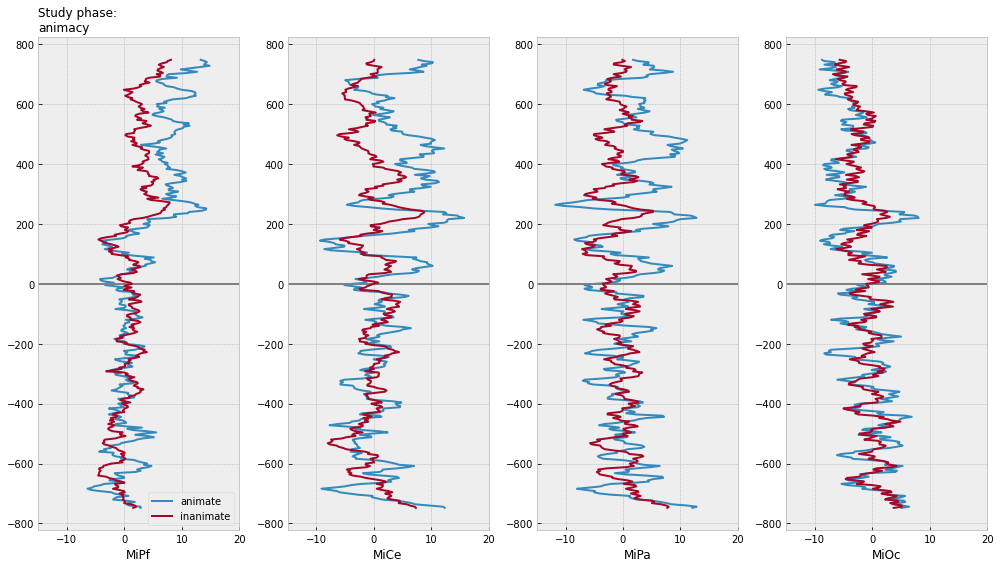

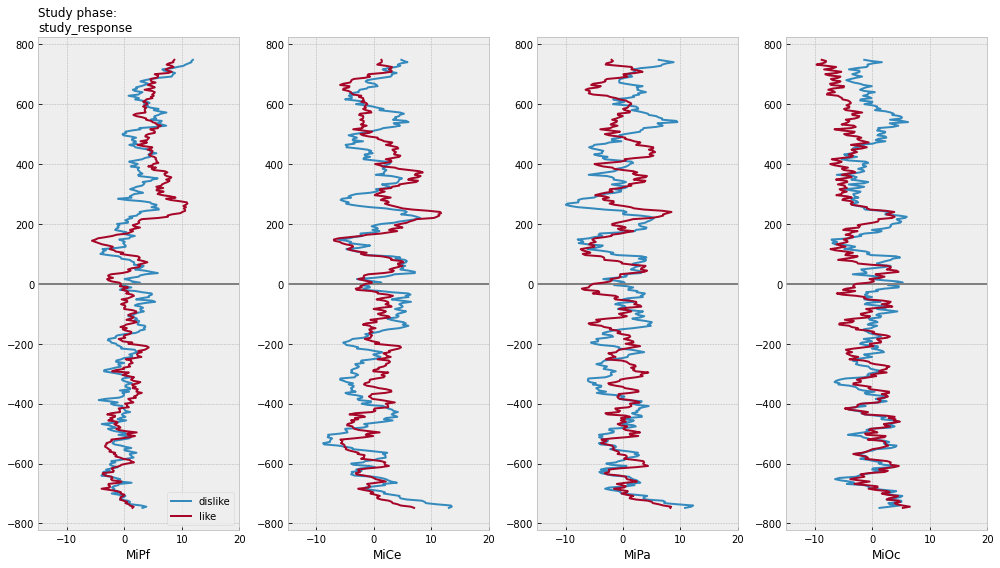

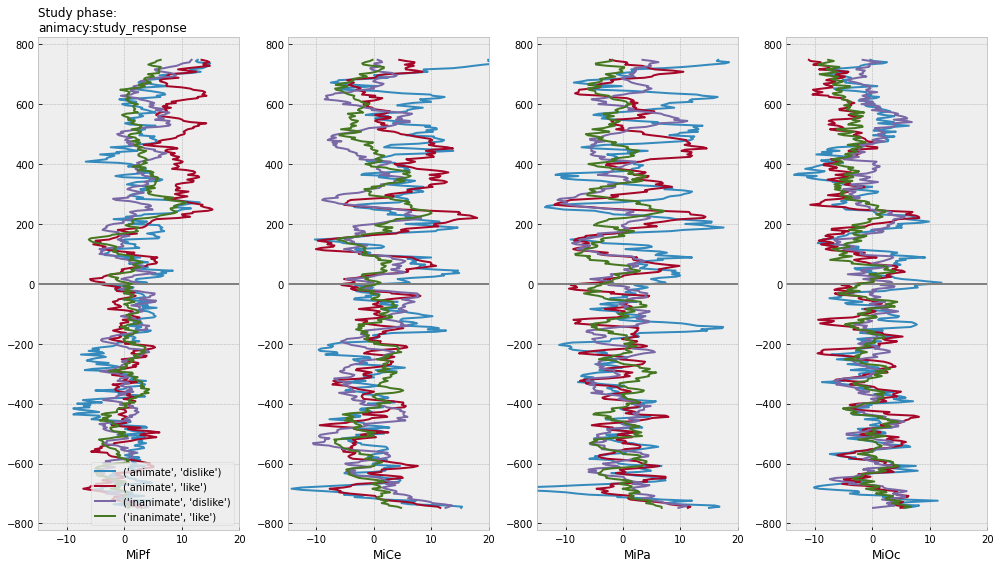

In [22]:
for grp in [["animacy"], ["study_response"], ["animacy", "study_response"]]:

    # compute domain average by stim type
    midline_erps = midline_epochs.groupby(
        grp + ["match_time"]
    ).mean().reset_index()

    # plot
    f, axs = plt.subplots(1, 4, figsize=(14,8), sharex=True)
    for rep, erp in midline_erps.groupby(grp):
        for axi, chan in enumerate(midline):
        
            # mark onset
            axs[axi].axhline(0, color='gray')
        
            # plot erp
            axs[axi].plot(
                erp[chan],
                erp["match_time"],
                label=f"{rep}",
                lw=2,
            )

            # channel
            axs[axi].set(xlim=(-15, 20), xlabel=chan)

    axs[0].legend(loc="lower right")
    axs[0].set_title(f"Study phase:\n{':'.join(grp)}", fontsize=12, loc="left")
    f.tight_layout()


**test phase time-domain average ERPs**

In [23]:
# load and sanitize epoch_id for pandas index
pm_test_epochs = pd.read_hdf(MDE_HOME / "data/sub000pm.test_ms1500.epochs.pdh5", key = "test_ms1500")
pm_test_epochs['epoch_id'] = pm_test_epochs['epoch_id'].astype('int')
print(pm_test_epochs.columns)

# drop EEG epochs tagged as bad
pm_test_epochs = epf.drop_bad_epochs(
    pm_test_epochs, 
    bads_column="log_flags",
    epoch_id="epoch_id",
    time="match_time"
)

# check the good event counts after dropping artifacts
pm_test_good_events = pm_test_epochs.query("match_time == 0")

print("After excluding EEG artifacts")
display(
    pd.crosstab(
        [
            pm_test_good_events.ccode, 
            pm_test_good_events.animacy,
            pm_test_good_events.test_response, 
        ],
        [
            pm_test_good_events.log_flags
        ],
        margins=True
    )
)

Index(['epoch_id', 'data_group', 'dblock_path', 'dblock_tick_idx',
       'dblock_ticks', 'crw_ticks', 'raw_evcodes', 'log_evcodes', 'log_ccodes',
       'log_flags', 'epoch_match_tick_delta', 'epoch_ticks', 'dblock_srate',
       'match_group', 'idx', 'dlim', 'anchor_str', 'match_str', 'anchor_code',
       'match_code', 'anchor_tick', 'match_tick', 'anchor_tick_delta',
       'is_anchor', 'regexp', 'test_bin_id', 'animacy', 'stimulus',
       'test_response', 'accuracy', 'ccode', 'phase', 'condition_id', 'jpg',
       'scn', 'study_response', 'match_time', 'anchor_time',
       'anchor_time_delta', 'pygarv', 'lle', 'lhz', 'MiPf', 'LLPf', 'RLPf',
       'LMPf', 'RMPf', 'LDFr', 'RDFr', 'LLFr', 'RLFr', 'LMFr', 'RMFr', 'LMCe',
       'RMCe', 'MiCe', 'MiPa', 'LDCe', 'RDCe', 'LDPa', 'RDPa', 'LMOc', 'RMOc',
       'LLTe', 'RLTe', 'LLOc', 'RLOc', 'MiOc', 'A2', 'HEOG', 'rle', 'rhz'],
      dtype='object')


After excluding EEG artifacts


log_flags                       0  All
ccode animacy   test_response         
1     animate   new            14   14
                old            13   13
      inanimate new            31   31
                old            35   35
All                            93   93

In [24]:
# for illustration ... 
midline = ["MiPf", "MiCe", "MiPa", "MiOc"]

# select COLUMNS: epoch index, timestamps, event tags, and midline EEG columns
midline_epochs = pm_test_epochs[["epoch_id", "match_time", "animacy", "test_response"] + midline]

# select ROWS: use tag values to pick and choose
midline_epochs = midline_epochs.query("test_response in ['old', 'new']")

# center each channel 
midline_epochs = epf.center_eeg(
    midline_epochs, 
    midline, 
    -750, 0, 
    epoch_id="epoch_id", 
    time="match_time"
)

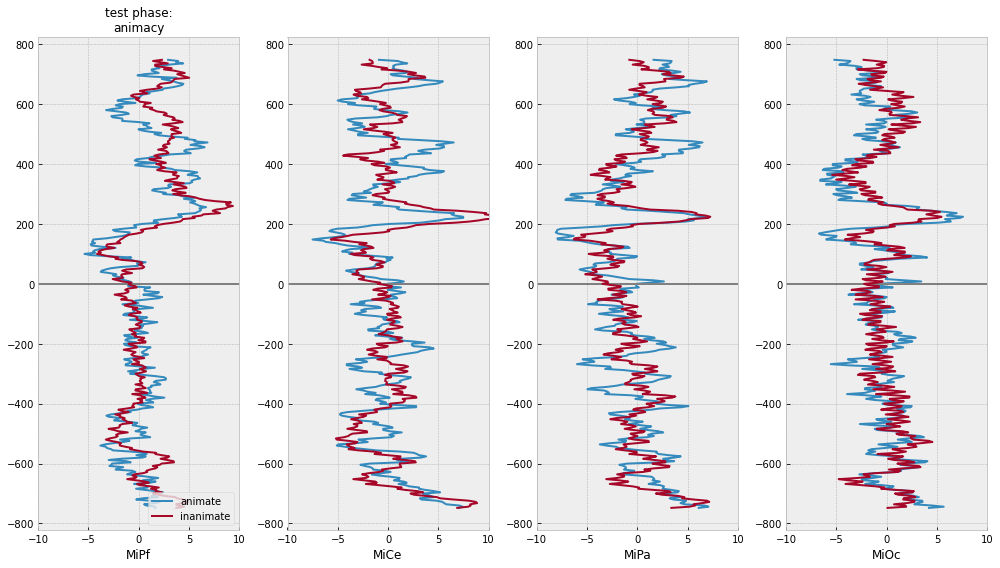

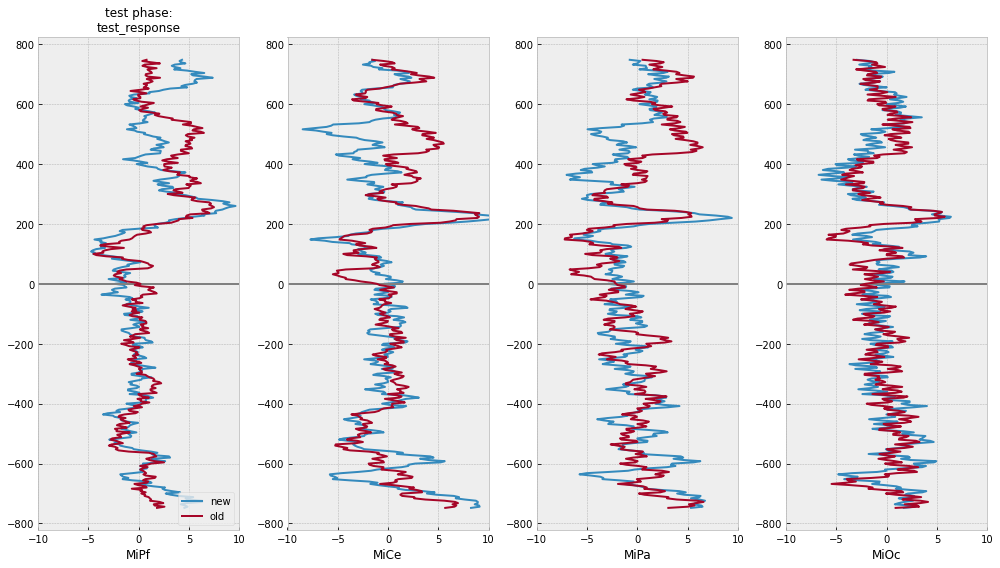

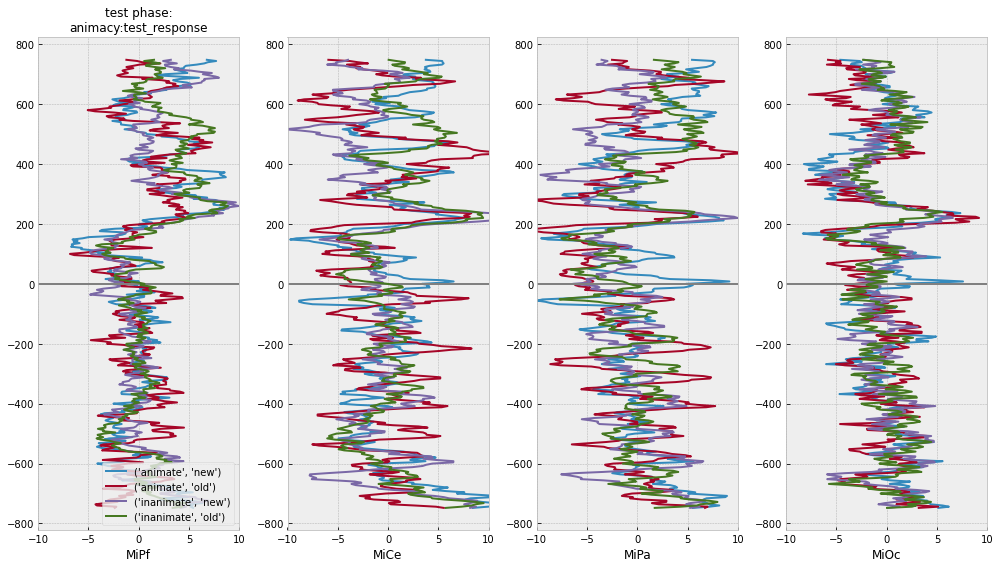

In [25]:
# plot separately and together
for grp in [["animacy"], ["test_response"], ["animacy", "test_response"]]:

    # compute domain average by stim type
    midline_erps = midline_epochs.groupby(
        grp + ["match_time"]
    ).mean().reset_index()

    # plot
    f, axs = plt.subplots(1, 4, figsize=(14,8))

    for (rep), erp in midline_erps.groupby(grp):
        for axi, chan in enumerate(midline):
        
            # mark onset
            axs[axi].axhline(0, color='gray')
        
            # plot erp
            axs[axi].plot(
                erp[chan],
                erp["match_time"],
                label=f"{rep}",
                lw=2,
            )

            axs[axi].set(xlim=(-10, 10), xlabel=chan)
            

    axs[0].legend(loc="lower right")
    axs[0].set_title(f"test phase:\n{':'.join(grp)}", fontsize=12)
    f.tight_layout()


**Single subject pipeline with epoch export in different formats**

build and calibrate the mkpy HDF5 format data file

1. get_event_table(*codemap*) and 

    **modify the event tables** 
    
   
2. set_epoch_table(*name*, *event_table*, *pre*, *post*)        
3. export_epochs(*name*, *file_format=...*)

In [26]:
# convert to HDF5 and calibrate
pm_h5 = mkh5.mkh5(pm_h5_f)
pm_h5.reset_all()
pm_h5.create_mkdata("sub000", crw, log, yhdr)

pm_h5.append_mkdata("sub000", cals_crw, cals_log, cals_yhdr)

pts, pulse, lo, hi, ccode = 5, 10, -40, 40, 0
pm_h5.calibrate_mkdata(
    "sub000",  
    n_points=pts, 
    cal_size=pulse,
    lo_cursor=lo,
    hi_cursor=hi,
    cal_ccode=ccode,
)

# 1. scan study and test phase events into the event tables
pm_test_study_table = pm_h5.get_event_table(pm_study_codemap_f)
pm_test_event_table = pm_h5.get_event_table(pm_test_codemap_f)

# --------------------------------------------
# MODIFY THE STUDY AND TEST PHASE EVENT TABLES
# ---------------------------------------------

# 1.1 prune both event tables to unique single trials

# study phase response tagged single trials are coded 
# with study table bin id > 2000
pm_study_events_for_epochs = pm_study_event_table.query(
    "is_anchor==True and study_bin_id >= 2000"
).copy().set_index("item_id").sort_index()

# test phase response-tagged single trials are coded
# with test table bin id > 1000
pm_test_events_for_epochs = pm_test_event_table.query(
    "is_anchor==True and test_bin_id >= 1000"
).copy().set_index("item_id").sort_index()

# 1.2 align the study phase items with subsequent test phase subsequent responses
pm_study_events_for_epochs = (
    pm_study_events_for_epochs
    .join(
        pm_test_events_for_epochs[test_s_r_cols],
        how="left",
        on="item_id",
    )
)

# 1.3 align test phase items with the previous study phase like/dislike responses 
pm_test_events_for_epochs = (
    pm_test_events_for_epochs
    .join(
        pm_study_events_for_epochs["study_response"],
        how="left",
        on="item_id",
    )
)


# ---------------------------------------------
# Set and export epochs
# ---------------------------------------------
epoch_specs  = {
    # epoch_name: (pre, post)
    "ms100": (-50, 50),
    "ms1500": (-750, 750),
    "ms3000": (-1500, 1500),
    "ms10000": (-5000, 5000),
}

# loop on the phases
phases = {
    "study": pm_study_events_for_epochs, 
    "test": pm_test_events_for_epochs
}
for phase, events in phases.items():
    for epoch_name, (pre, post) in epoch_specs.items():
        
        key=f"{phase}_{epoch_name}"
        print(key, pre, post)

        pm_h5.set_epochs(key, events, pre, post)
        
        # multiple export formats for demonstration, in practice pick one
        fformats = ["h5", "pdh5", "feather"]
        for ffmt in fformats:
            _fname = f"{MDE_HOME}/data/sub000pm.{key}.epochs.{ffmt}"
            print(f"exporting pm {key} as {ffmt}: {_fname}")

            # this exports the epochs DATA ... EEG and events.
            pm_h5.export_epochs(key, _fname, file_format=ffmt)


/home/turbach/miniconda3/envs/mkconda_for_sphinxdocs/lib/python3.6/site-packages/mkpy/mkh5.py:3706: UserWarning: negative event code(s) found for cal condition code 0 -16384
  warnings.warn(msg)


Found cals in /sub000/dblock_3
Calibrating block /sub000/dblock_0 of 4: (95232,)  


Calibrating block /sub000/dblock_1 of 4: (34048,)  


Calibrating block /sub000/dblock_2 of 4: (139008,)  


Calibrating block /sub000/dblock_3 of 4: (28416,)  


/home/turbach/miniconda3/envs/mkconda_for_sphinxdocs/lib/python3.6/site-packages/mkpy/mkh5.py:1060: UserWarning: 
As of mkpy 0.2.0 to match events with a codemap regexp pattern, the
ccode column in pm_study_codemap.tsv must also match the log_ccode
in the datablock. If this behavior is not desired, delete or rename
the ccode column in the codemap.
  warnings.warn(msg)


searching codes in: sub000/dblock_0


searching codes in: sub000/dblock_1


searching codes in: sub000/dblock_2


searching codes in: sub000/dblock_3


/home/turbach/miniconda3/envs/mkconda_for_sphinxdocs/lib/python3.6/site-packages/mkpy/mkh5.py:1060: UserWarning: 
As of mkpy 0.2.0 to match events with a codemap regexp pattern, the
ccode column in pm_codemap.tsv must also match the log_ccode
in the datablock. If this behavior is not desired, delete or rename
the ccode column in the codemap.
  warnings.warn(msg)


searching codes in: sub000/dblock_0


searching codes in: sub000/dblock_1


searching codes in: sub000/dblock_2


searching codes in: sub000/dblock_3


study_ms100 -50 50
Sanitizing event table data types for mkh5 epochs table ...


exporting pm study_ms100 as h5: /mnt/cube/home/turbach/TPU_Projects/mkpy_data_examples/data/sub000pm.study_ms100.epochs.h5
exporting pm study_ms100 as pdh5: /mnt/cube/home/turbach/TPU_Projects/mkpy_data_examples/data/sub000pm.study_ms100.epochs.pdh5


exporting pm study_ms100 as feather: /mnt/cube/home/turbach/TPU_Projects/mkpy_data_examples/data/sub000pm.study_ms100.epochs.feather


study_ms1500 -750 750
Sanitizing event table data types for mkh5 epochs table ...


exporting pm study_ms1500 as h5: /mnt/cube/home/turbach/TPU_Projects/mkpy_data_examples/data/sub000pm.study_ms1500.epochs.h5


exporting pm study_ms1500 as pdh5: /mnt/cube/home/turbach/TPU_Projects/mkpy_data_examples/data/sub000pm.study_ms1500.epochs.pdh5


exporting pm study_ms1500 as feather: /mnt/cube/home/turbach/TPU_Projects/mkpy_data_examples/data/sub000pm.study_ms1500.epochs.feather


study_ms3000 -1500 1500
Sanitizing event table data types for mkh5 epochs table ...


exporting pm study_ms3000 as h5: /mnt/cube/home/turbach/TPU_Projects/mkpy_data_examples/data/sub000pm.study_ms3000.epochs.h5


exporting pm study_ms3000 as pdh5: /mnt/cube/home/turbach/TPU_Projects/mkpy_data_examples/data/sub000pm.study_ms3000.epochs.pdh5


exporting pm study_ms3000 as feather: /mnt/cube/home/turbach/TPU_Projects/mkpy_data_examples/data/sub000pm.study_ms3000.epochs.feather


study_ms10000 -5000 5000
Sanitizing event table data types for mkh5 epochs table ...


/home/turbach/miniconda3/envs/mkconda_for_sphinxdocs/lib/python3.6/site-packages/mkpy/mkh5.py:1514: UserWarning: data error: pre-stimulus interval is out of bounds left ... skipping epoch (27, b'sub000', b'sub000/dblock_0', 1, 834, 834, 2, 2, 2, 32, 0, 1, 250., 1, 1, 3, b'2', b'2', 2, 2, 834, 834, 0, True, b'(#[2]) 8 (154) 1040', 2200, b'inanimate', b'like', 2, b'study', 2, b'necklace', b'studyp1', b'old', b'hit')
  + "skipping epoch {0}".format(e)


exporting pm study_ms10000 as h5: /mnt/cube/home/turbach/TPU_Projects/mkpy_data_examples/data/sub000pm.study_ms10000.epochs.h5


exporting pm study_ms10000 as pdh5: /mnt/cube/home/turbach/TPU_Projects/mkpy_data_examples/data/sub000pm.study_ms10000.epochs.pdh5


exporting pm study_ms10000 as feather: /mnt/cube/home/turbach/TPU_Projects/mkpy_data_examples/data/sub000pm.study_ms10000.epochs.feather


test_ms100 -50 50


Sanitizing event table data types for mkh5 epochs table ...


exporting pm test_ms100 as h5: /mnt/cube/home/turbach/TPU_Projects/mkpy_data_examples/data/sub000pm.test_ms100.epochs.h5


exporting pm test_ms100 as pdh5: /mnt/cube/home/turbach/TPU_Projects/mkpy_data_examples/data/sub000pm.test_ms100.epochs.pdh5


exporting pm test_ms100 as feather: /mnt/cube/home/turbach/TPU_Projects/mkpy_data_examples/data/sub000pm.test_ms100.epochs.feather


test_ms1500 -750 750


Sanitizing event table data types for mkh5 epochs table ...


exporting pm test_ms1500 as h5: /mnt/cube/home/turbach/TPU_Projects/mkpy_data_examples/data/sub000pm.test_ms1500.epochs.h5


exporting pm test_ms1500 as pdh5: /mnt/cube/home/turbach/TPU_Projects/mkpy_data_examples/data/sub000pm.test_ms1500.epochs.pdh5


exporting pm test_ms1500 as feather: /mnt/cube/home/turbach/TPU_Projects/mkpy_data_examples/data/sub000pm.test_ms1500.epochs.feather


test_ms3000 -1500 1500


Sanitizing event table data types for mkh5 epochs table ...


/home/turbach/miniconda3/envs/mkconda_for_sphinxdocs/lib/python3.6/site-packages/mkpy/mkh5.py:1514: UserWarning: data error: pre-stimulus interval is out of bounds left ... skipping epoch (81, b'sub000', b'sub000/dblock_2', 1, 280, 129560, 2, 2, 1, 0, 0, 1, 250., 1, 1, 3, b'2', b'2', 2, 2, 280, 280, 0, True, b'(#2) 8 (182) 2064', 1200, b'inanimate', b'distractor', b'new', b'cr', 1, b'test', b'2', b'stapler', b'testp1', b'.NAN')
  + "skipping epoch {0}".format(e)


exporting pm test_ms3000 as h5: /mnt/cube/home/turbach/TPU_Projects/mkpy_data_examples/data/sub000pm.test_ms3000.epochs.h5


exporting pm test_ms3000 as pdh5: /mnt/cube/home/turbach/TPU_Projects/mkpy_data_examples/data/sub000pm.test_ms3000.epochs.pdh5


exporting pm test_ms3000 as feather: /mnt/cube/home/turbach/TPU_Projects/mkpy_data_examples/data/sub000pm.test_ms3000.epochs.feather


test_ms10000 -5000 5000
Sanitizing event table data types for mkh5 epochs table ...


/home/turbach/miniconda3/envs/mkconda_for_sphinxdocs/lib/python3.6/site-packages/mkpy/mkh5.py:1514: UserWarning: data error: pre-stimulus interval is out of bounds left ... skipping epoch (26, b'sub000', b'sub000/dblock_1', 1, 611, 95843, 1, 1, 1, 0, 0, 1, 250., 1, 1, 3, b'1', b'1', 1, 1, 611, 611, 0, True, b'(#1) 2064 8 (127)', 1102, b'animate', b'distractor', b'new', b'cr', 1, b'test', b'1', b'dragon', b'testp1', b'.NAN')
  + "skipping epoch {0}".format(e)


exporting pm test_ms10000 as h5: /mnt/cube/home/turbach/TPU_Projects/mkpy_data_examples/data/sub000pm.test_ms10000.epochs.h5


exporting pm test_ms10000 as pdh5: /mnt/cube/home/turbach/TPU_Projects/mkpy_data_examples/data/sub000pm.test_ms10000.epochs.pdh5


exporting pm test_ms10000 as feather: /mnt/cube/home/turbach/TPU_Projects/mkpy_data_examples/data/sub000pm.test_ms10000.epochs.feather
